### Packages and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex" : "True",
    "font.family": "Times"
})

from tqdm import tqdm

from scipy.linalg import eigh, norm, expm
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.sparse.linalg import expm_multiply

In [2]:
def Ham_ST(N,eps_a,eps_b,t_aa,t_ab,t_bb,omega0,g,n_site):
    
    H = np.diag([eps_b/2,eps_a/2]*N + [omega0/2])
    H += np.diag([-t_ab]*(2*N -1) + [0],k=1)
    H += np.diag([-t_bb,-t_aa]*(N-1) + [0],k=2)

    H[0,2*N-2] -= t_bb
    H[0,2*N-1] -= t_ab
    H[n_site,-1] -= g #coupling to an A site in the middle

    H += np.conjugate(H.transpose())
    
    return H

In [3]:
def time_evol(H,tstart=0,tstop=1,Num=100,N_em=1,psi=[1.]):
    
    n = np.shape(H)[0]-N_em
    psi_in = np.array([0.]*n + psi)

    temp = expm_multiply(-1.j*H,psi_in,tstart,tstop,Num)
    
    return temp[:,-N_em:], temp[:,:-N_em]

In [4]:
def JC_atom(t,g,det):
    
    om = np.sqrt(det**2 + 4.*(g**2))
    
    return 1. - (4*(g**2)/(om**2))*np.sin(t*om/2)**2

# Quantum emitter coupled to the sawtooth lattice

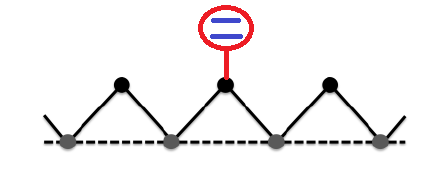

In [5]:
from IPython import display
display.Image("sawtooth_em.png")

In this notebook we study the coupling of several quantum emitters to the sawtooth lattice in different energetic and topological configurations.

First of all, we choose the number of unit cell $N$ and set the optimal parameters to get a flat band.

In [6]:
N = 100 #number of primitive cells
n = 2*N #number of points

eps_a = eps_b = 0.

t_aa = 0.
t_ab = np.sqrt(2)
t_bb = 1.

## Coupling to an A site

We choose here the transition frequency of the atom ($\omega_0$) and the coupling strenght $g$.
We couple the atom to an A site using the hamiltonian
\begin{equation}
    H = g \, (\sigma^+ a_n + \sigma^- a_n^{\dagger})
\end{equation}
where $\sigma^{+(-)}$ are the two-level atom (TLA) ladder operators and $a_n$ is the annihilation operator of a field excitation in the n-th A-site. 

In [67]:
omega0 = 2 #atom frequency
g = 0.1 #atom-cavity coupling

In [68]:
H = Ham_ST(N,eps_a,eps_b,t_aa,t_ab,t_bb,omega0,g,N-1)

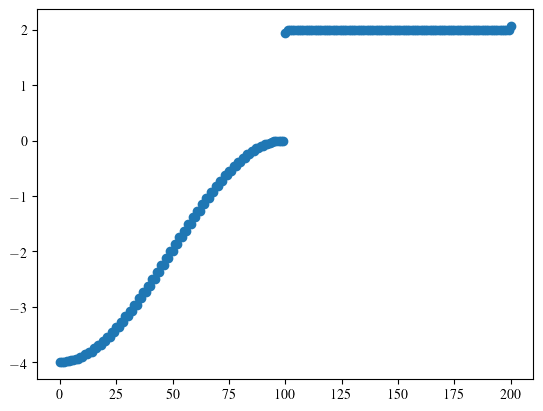

In [69]:
eigvals, _ = eigh(H)

fig = plt.figure()

plt.scatter(np.arange(0,2*N+1,1),eigvals)

plt.show()

We calculate the state
\begin{equation}
    |\Psi(t)\rangle = e^{-i\,H\,t} |e,vac\rangle
\end{equation}

In [70]:
t = np.linspace(0,150,300)
pop, phot = time_evol(H,t[0],t[-1],len(t))

We plot here the time evolution of the atomic part of the wavefunction.

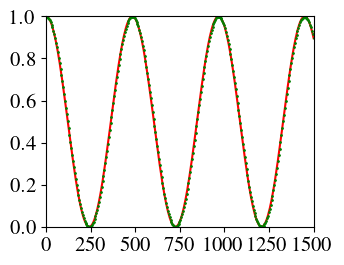

In [82]:
cm = 1/2.54
fig = plt.figure(figsize=(9*cm,7*cm),tight_layout=1)

fac = np.sqrt(1- 1/np.sqrt(3))
pop_at = np.real(pop[:,0]*np.conjugate(pop[:,0]))
plt.scatter(t/g,pop_at,c='green',s=1,zorder=2)
plt.plot(t/g,JC_atom(t,fac*g,omega0-2),c='red',zorder=1)

plt.xlim(0,t[-1]/g)
plt.ylim(0.,1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


#plt.savefig(f"plots/comp_A.pdf")
plt.show()

We search for the time at which the atomic population reaches its minimum value (for reference).

In [24]:
print("t :",np.where(pop_at == min(pop_at[:150]))[0][0])

t : 3


We compute the squared modulus of the photonic wavefunction.

In [11]:
pop_phot = np.zeros((n,len(t)))

for i in range(len(t)):
    pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))

ValueError: could not broadcast input array from shape (150,) into shape (200,)

We choose some time snaphots.

In [13]:
vec = [50,70,11]

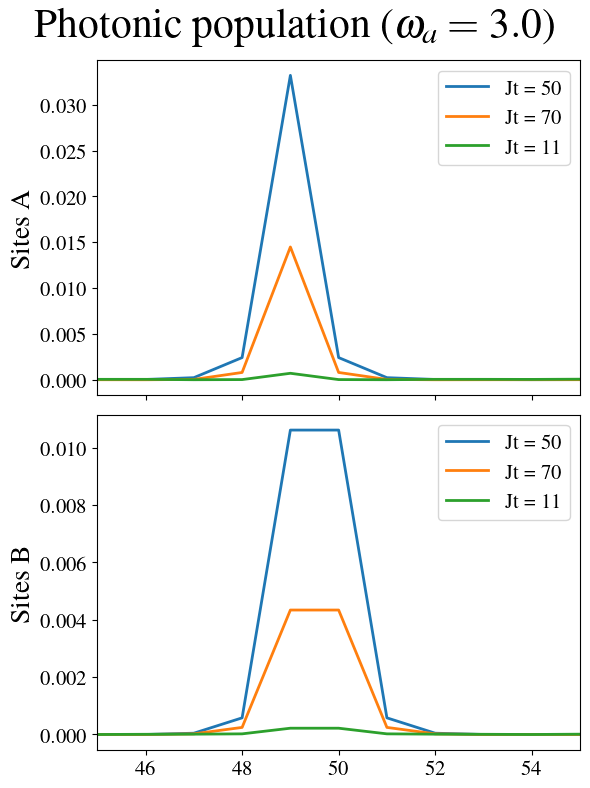

In [27]:
fig, ax = plt.subplots(figsize=(6,8),nrows=2,ncols=1,sharex=True,tight_layout=0)

for s in vec:
    ax[0].plot(pop_phot[1::2,s],label=f"Jt = {t[s]:.0f}",lw=2)
    ax[1].plot(pop_phot[::2,s],label=f"Jt = {t[s]:.0f}",lw=2)

plt.suptitle(f"Photonic population ($\omega_a = {omega0:.1f}$)",fontsize=30)

plt.xlim(N//2-5,N//2+5)
ax[0].set_ylabel("Sites A",fontsize=20)
ax[1].set_ylabel("Sites B",fontsize=20)

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)

plt.show()

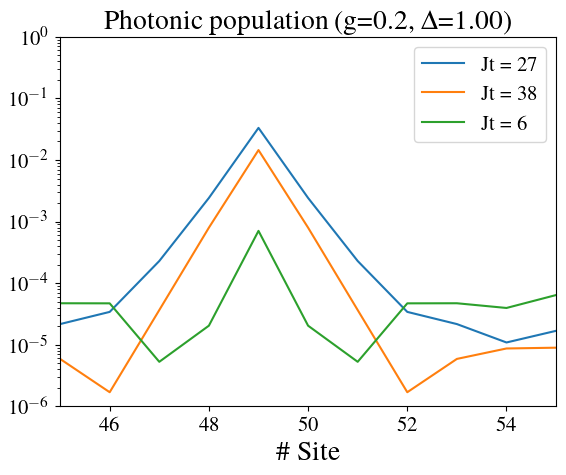

In [17]:
fig = plt.figure()

for s in vec:
    plt.plot(pop_phot[1::2,s],label=f"Jt = {t[s]:.0f}")

plt.title(f"Photonic population (g={g:.1f}, $\Delta$={omega0-2.:.2f})",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

plt.xlim(N//2-5,N//2+5)
plt.ylim(1e-6,1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)

plt.show()

## Coupling to a B site

We couple the atom to a B site using the hamiltonian
\begin{equation}
    H = g \, (\sigma^+ b_n + \sigma^- b_n^{\dagger})
\end{equation}
where $\sigma^{+(-)}$ are the two-level atom (TLA) ladder operators and $b_n$ is the annihilation operator of a field excitation in the n-th B-site. 

In [28]:
omega0 = 2.#atom frequency
g = 0.1 #atom-cavity coupling

In [29]:
H = Ham_ST(N,eps_a,eps_b,t_aa,t_ab,t_bb,omega0,g,N-2)

We calculate the state
\begin{equation}
    |\Psi(t)\rangle = e^{-i\,H\,t} |e,vac\rangle
\end{equation}

In [30]:
t = np.linspace(0,80,150)
pop, phot = time_evol(t,H)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 59.53it/s]


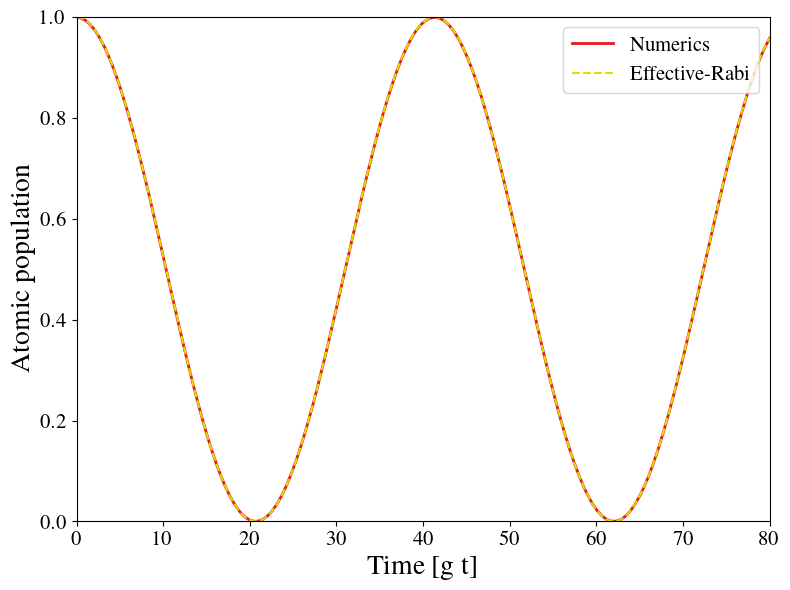

In [32]:
fig = plt.figure(figsize=(8,6),tight_layout=1)

fac = np.power(3,-1/4)
pop_at = np.real(pop*np.conjugate(pop))[0,:]
plt.plot(t,pop_at,c='#e41a1c',lw=2,label="Numerics")
plt.plot(t,JC_atom(t,fac*g,omega0-2),ls="--",label="Effective-Rabi",c='#dede00')

plt.xlabel("Time [g t]",fontsize=20)
plt.ylabel(f"Atomic population",fontsize=20)

plt.xlim(0,t[-1])
plt.ylim(0.,1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15,loc=1)

plt.show()

We search for the time at which the atomic population reaches its minimum value (for reference).

In [33]:
print("t :",np.where(pop_at == min(pop_at[:150]))[0][0])

t : 116


We compute the squared modulus of the photonic wavefunction.

In [34]:
pop_phot = np.zeros((n,len(t)))

for i in range(len(t)):
    pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))

We choose some time snaphots.

In [35]:
vec = [6,25,50]

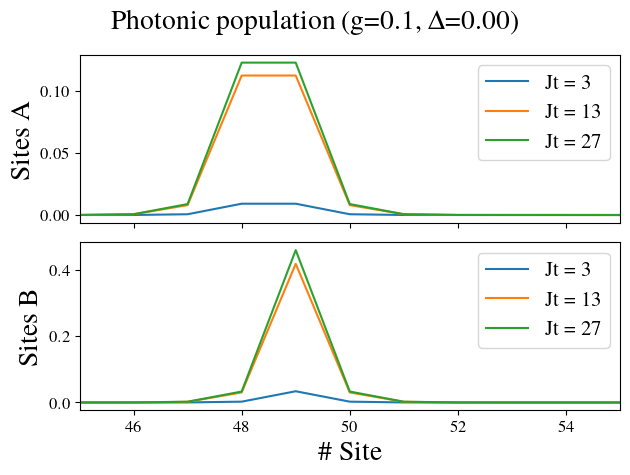

In [37]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=True)

for s in vec:
    ax[0].plot(pop_phot[1::2,s],label=f"Jt = {t[s]:.0f}")
    ax[1].plot(pop_phot[::2,s],label=f"Jt = {t[s]:.0f}")


plt.suptitle(f"Photonic population (g={g:.1f}, $\Delta$={omega0-2.:.2f})",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

plt.xlim(N//2 - 5,N//2 + 5)
ax[0].set_ylabel("Sites A",fontsize=20)
ax[1].set_ylabel("Sites B",fontsize=20)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)


plt.show()

## Comparison

### Equal g, different $\omega_0$

In [38]:
omega0 = np.arange(1.5,2.51,0.1)
g = 0.1

In [39]:
t = [10.]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.55it/s]


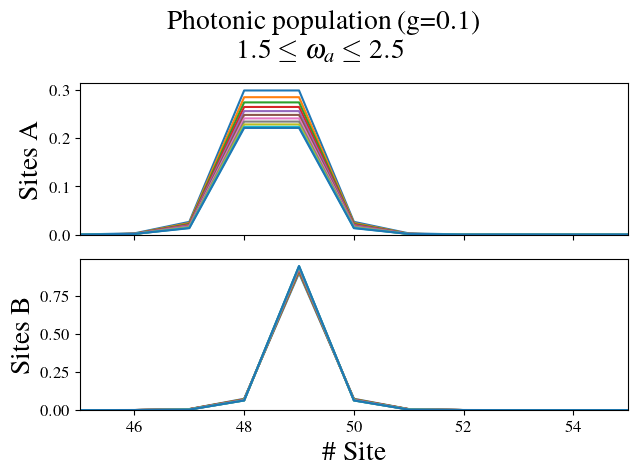

In [43]:
fig, ax = plt.subplots(nrows=2,ncols=1,tight_layout=True,sharex=1)

for s in range(len(omega0)):
    H = Ham_ST(N,eps_a,eps_b,t_aa,t_ab,t_bb,omega0[s],g,N-2)
    pop, phot = time_evol(t,H)
    
    pop_phot = np.zeros((n,len(t)))
    for i in range(len(t)):
        pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))
        temp = norm(pop_phot[:,i])
        pop_phot[:,i] /= temp

    ax[0].plot(pop_phot[1::2,0],label=f"$\omega_0$ = {omega0[s]:.1f}")
    ax[1].plot(pop_phot[::2,0])


plt.suptitle(f"Photonic population (g={g:.1f})\n $1.5 \leq \omega_a \leq 2.5$",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

ax[0].set_xlim(N//2-5,N//2+5)
ax[0].set_ylim(0)
ax[1].set_ylim(0)
ax[0].set_ylabel("Sites A",fontsize=20)
ax[1].set_ylabel("Sites B",fontsize=20)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
#ax[0].legend()

#plt.savefig("comp_omega_B.png")

plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.64it/s]


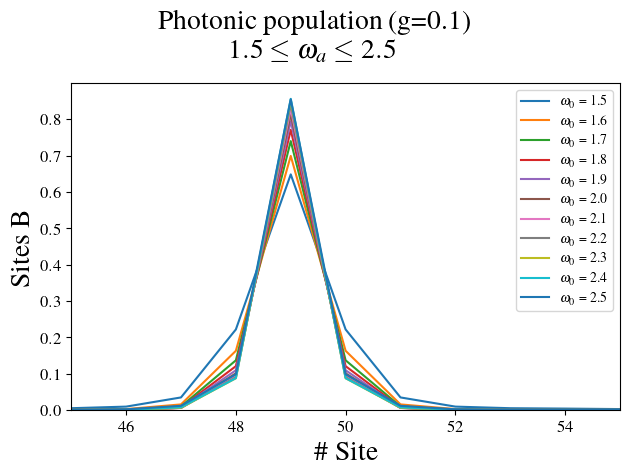

In [45]:
fig, ax = plt.subplots(tight_layout=True)

for s in range(len(omega0)):
    H = Ham_ST(N,eps_a,eps_b,t_aa,t_ab,t_bb,omega0[s],g,N-1)
    pop, phot = time_evol(t,H)
    
    pop_phot = np.zeros((n,len(t)))
    for i in range(len(t)):
        pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))
        temp = norm(pop_phot[:,i])
        pop_phot[:,i] /= temp

    ax.plot(pop_phot[1::2,0],label=f"$\omega_0$ = {omega0[s]:.1f}")


plt.suptitle(f"Photonic population (g={g:.1f})\n $1.5 \leq \omega_a \leq 2.5$",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

ax.set_xlim(N//2-5,N//2+5)
ax.set_ylim(0)
ax.set_ylabel("Sites B",fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()

#plt.savefig("comp_omega2.png",dpi=400)

plt.show()

### Equal $\omega_0$, different g

In [46]:
omega0 = 2.
g = [0.01,0.05,0.07,0.1,0.15,0.2,0.3,0.4]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.55it/s]


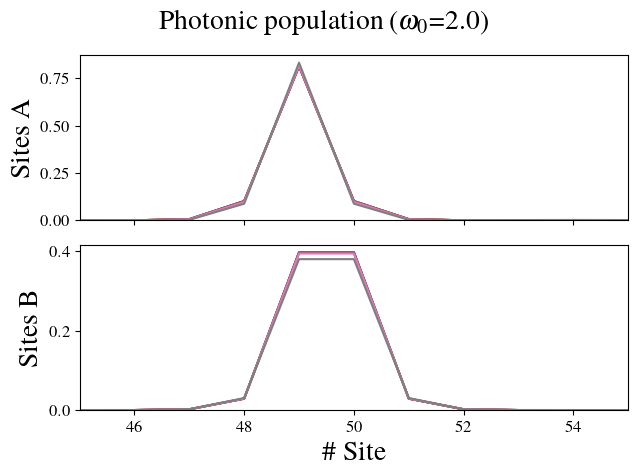

In [47]:
fig, ax = plt.subplots(nrows=2,ncols=1,tight_layout=True,sharex=1)

for s in range(len(g)):
    H = Ham_ST(N,eps_a,eps_b,t_aa,t_ab,t_bb,omega0,g[s],N-1)
    pop, phot = time_evol(t,H)
    
    pop_phot = np.zeros((n,len(t)))
    for i in range(len(t)):
        pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))
        temp = norm(pop_phot[:,i])
        pop_phot[:,i] /= temp

    ax[0].plot(pop_phot[1::2,0],label=f"$g = {g[s]:.2f}")
    ax[1].plot(pop_phot[::2,0])


plt.suptitle(f"Photonic population ($\omega_0$={omega0:.1f})",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

ax[0].set_xlim(N//2-5,N//2+5)
ax[0].set_ylim(0)
ax[1].set_ylim(0)
ax[0].set_ylabel("Sites A",fontsize=20)
ax[1].set_ylabel("Sites B",fontsize=20)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
#ax[0].legend()

#plt.savefig("comp_g.png")

plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.23it/s]


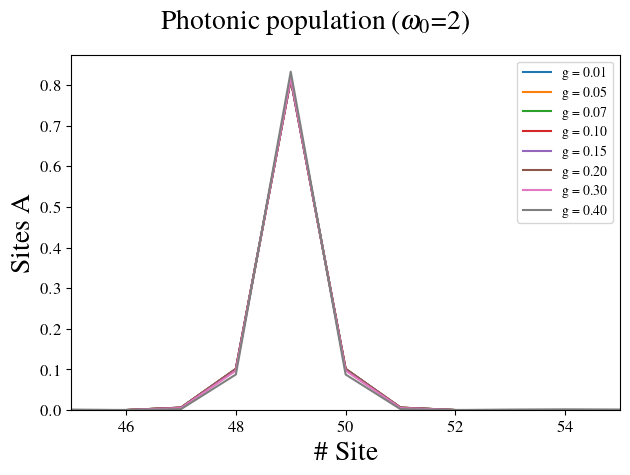

In [48]:
fig, ax = plt.subplots(tight_layout=True)

for s in range(len(g)):
    H = Ham_ST(N,eps_a,eps_b,t_aa,t_ab,t_bb,omega0,g[s],N-1)
    pop, phot = time_evol(t,H)
    
    pop_phot = np.zeros((n,len(t)))
    for i in range(len(t)):
        pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))
        temp = norm(pop_phot[:,i])
        pop_phot[:,i] /= temp

    ax.plot(pop_phot[1::2,0],label=f"g = {g[s]:.2f}")


plt.suptitle(f"Photonic population ($\omega_0$={omega0:.0f})",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

ax.set_xlim(N//2-5,N//2+5)
ax.set_ylim(0)
ax.set_ylabel("Sites A",fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()

#plt.savefig("comp_g2.png",dpi=400)

plt.show()

# Two quantum emitters coupled to the sawtooth lattice

We couple locally two quantum emitters to the sawtooth lattice. In the following, $d$ is the distance between coupling points. 

In [61]:
omega1 = 2 #atom frequency
omega2 = 5.5
g = 0.1 #atom-cavity coupling

In [62]:
H = np.diag([eps_b/2,eps_a/2]*N + [omega1/2,omega2/2])
H += np.diag([-t_ab]*(2*N -1) + [0,0],k=1)
H += np.diag([-t_bb,-t_aa]*(N-1) + [0,0],k=2)

d = 4#d/2 is the distance
H[0,n-2] -= t_bb
H[0,n-1] -= t_ab

H[N,-1] -= g
H[N+d,-2] -= g

H += np.conjugate(H.transpose())

In [63]:
t = np.linspace(0,500,1000)
pop, phot = time_evol(H,t[0],t[-1],len(t),2,[1.,0.])

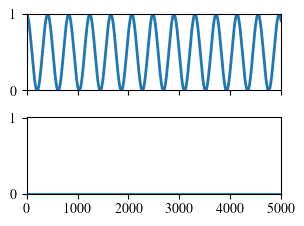

In [64]:
cm = 1/2.54
fig, ax = plt.subplots(figsize=(8*cm,6*cm),nrows=2,ncols=1,sharex=True,tight_layout=1)

t /= g

ax[0].plot(t,pop[:,0]*np.conjugate(pop[:,0]),zorder=1,lw=2)
ax[1].plot(t,pop[:,1]*np.conjugate(pop[:,1]),zorder=1,lw=2)

#ax[0].plot(t,pop1[:,0]*np.conjugate(pop1[:,0]),zorder=1,lw=2)
#ax[1].plot(t,pop1[:,1]*np.conjugate(pop1[:,1]),zorder=1,lw=2)

#ax[0].plot(t,pop2[:,0]*np.conjugate(pop2[:,0]),zorder=1,lw=2)
#ax[1].plot(t,pop2[:,1]*np.conjugate(pop2[:,1]),zorder=1,lw=2)


ax[0].set_xlim(0,t[-1])
ax[0].set_ylim(0.,1.01)
ax[1].set_ylim(0.,1.01)
#ax[0].legend()

#plt.savefig(f"CLS.pdf")
plt.show()

In [84]:
pop_phot = np.zeros((n,len(t)))

for i in range(len(t)):
    pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))

In [95]:
vec = [10,400,700]

In the following, especially looking at the photon population on B sites, it can be noticed how atoms exchange the excitation during the evolution through the field.

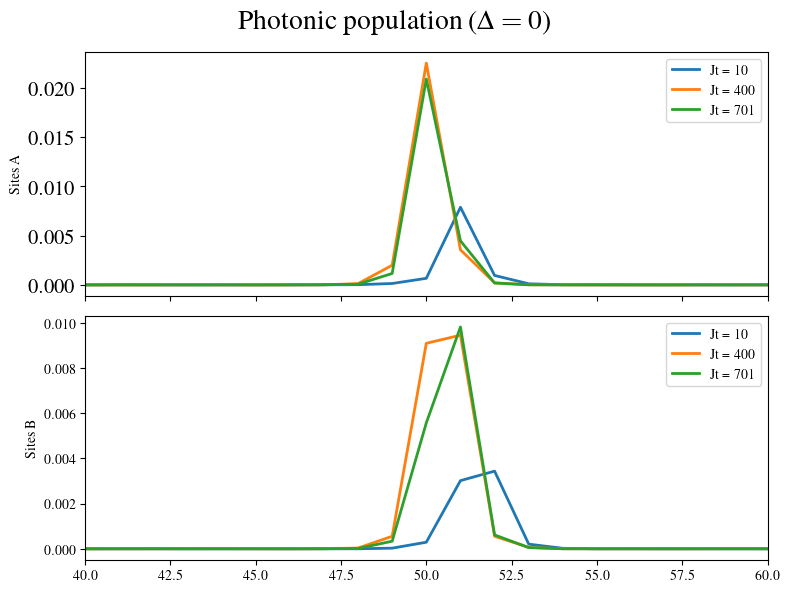

In [96]:
fig, ax = plt.subplots(figsize=(8,6),nrows=2,ncols=1,sharex=True,tight_layout=0)

for s in vec:
    ax[0].plot(pop_phot[1::2,s],label=f"Jt = {t[s]:.0f}",lw=2)
    ax[1].plot(pop_phot[::2,s],label=f"Jt = {t[s]:.0f}",lw=2)


plt.suptitle(f"Photonic population ($\Delta = 0$)",fontsize=20)
#plt.xlabel("\# Site",fontsize=20)

plt.xlim(N//2-10,N//2+10)
ax[0].set_ylabel("Sites A",fontsize=10)
ax[1].set_ylabel("Sites B",fontsize=10)

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[0].legend(fontsize=10)
ax[1].legend(fontsize=10)

#plt.savefig(f"two_em/ev_phot_ab_{d//2}.png")
plt.show()

# A giant atom coupled to the sawtooth lattice

We use giant atoms to engineer couplings to multiple points. The resulting interaction hamiltonian will be in the form
\begin{equation}
    H = \sum_{p,\xi} (g_p\,e^{-ikx_p} \, \xi^\dagger_p \, \sigma^- + \text{h. c.}) 
\end{equation}
where the index $p$ runs over all the touching points.

## Isolating the FB

In this section, we show how it is possible to control the shape of the atom-photon bound state by engineering the non-local coupling of the giant atom.

In [188]:
omega0 = 2.5 #atom frequency
g = 0.1 #atom-cavity coupling

We choose $h_n = \frac{1}{\ell} e^{-x_n/\ell}$.

In [189]:
x = np.arange(0,N,1)
l = 0.5 # localization lenght

vec_b = -np.sqrt(2)*np.exp(-abs(x-(N//2))/l)/l
vec_a = np.zeros(N)
vec_a[:N//2] = np.exp(-abs(x[:N//2]-(N//2))/l)/l + np.exp(-abs(x[:N//2]-(N//2)-1)/l)/l
vec_a[N//2:] = np.flip(vec_a[:N//2])

We normalize the state.

In [190]:
c = np.sqrt(np.sum(vec_a**2) + np.sum(vec_b**2))

Here, we define the hamiltonian.

In [191]:
H = np.diag([eps_b/2,eps_a/2]*N + [omega0/2])
H += np.diag([-t_ab]*(2*N -1) + [0],k=1)
H += np.diag([-t_bb,-t_aa]*(N-1) + [0],k=2)

H[0,2*N-2] -= t_bb
H[0,2*N-1] -= t_ab

H[:-1:2,-1] = vec_b*g/c
H[1:-1:2,-1] = vec_a*g/c

H += np.conjugate(H.transpose())

In [192]:
t = np.linspace(0,100,100)
pop, phot = time_evol(t,H)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.97it/s]


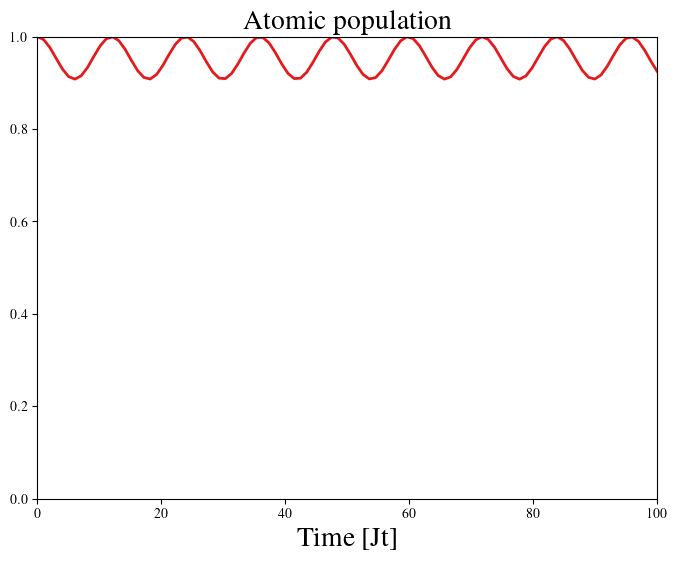

In [193]:
fig = plt.figure(figsize=(8,6))

pop_at = np.real(pop[0]*np.conjugate(pop[0]))
plt.plot(t,pop_at,c='#e41a1c',lw=2,label="Data")

plt.title(f"Atomic population",fontsize=20)
plt.xlabel("Time [Jt]",fontsize=20)

plt.xlim(0,t[-1])
plt.ylim(0.,1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [194]:
pop_phot = np.zeros((2*N,len(t)))

for i in range(len(t)):
    pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))

In [195]:
vec = [10,50,60]

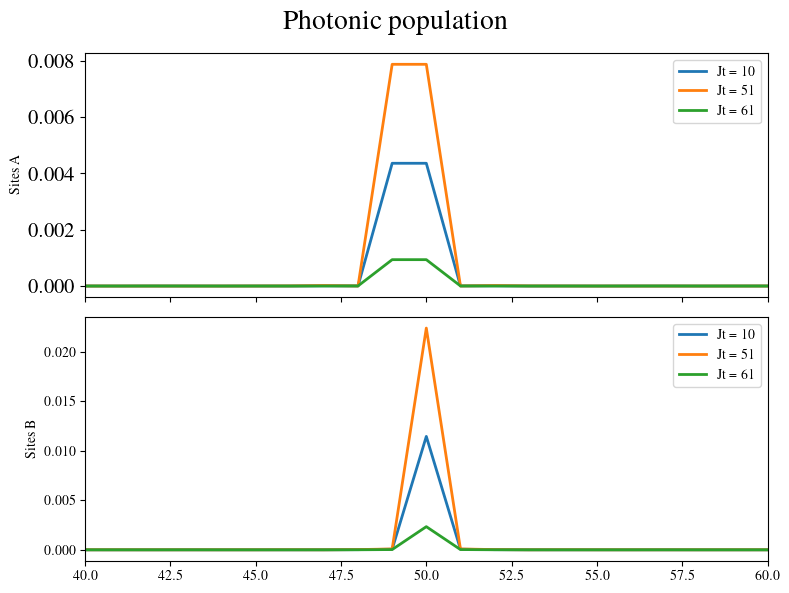

In [198]:
fig, ax = plt.subplots(figsize=(8,6),nrows=2,ncols=1,sharex=True,tight_layout=0)

for s in vec:
    ax[0].plot(pop_phot[1::2,s],label=f"Jt = {t[s]:.0f}",lw=2)
    ax[1].plot(pop_phot[::2,s],label=f"Jt = {t[s]:.0f}",lw=2)

plt.suptitle(f"Photonic population",fontsize=20)

plt.xlim(N//2 - 10,N//2 + 10)
ax[0].set_ylabel("Sites A",fontsize=10)
ax[1].set_ylabel("Sites B",fontsize=10)


ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[0].legend(fontsize=10)
ax[1].legend(fontsize=10)


plt.show()

Here we compare the shape of the states during evolution to the couplings.

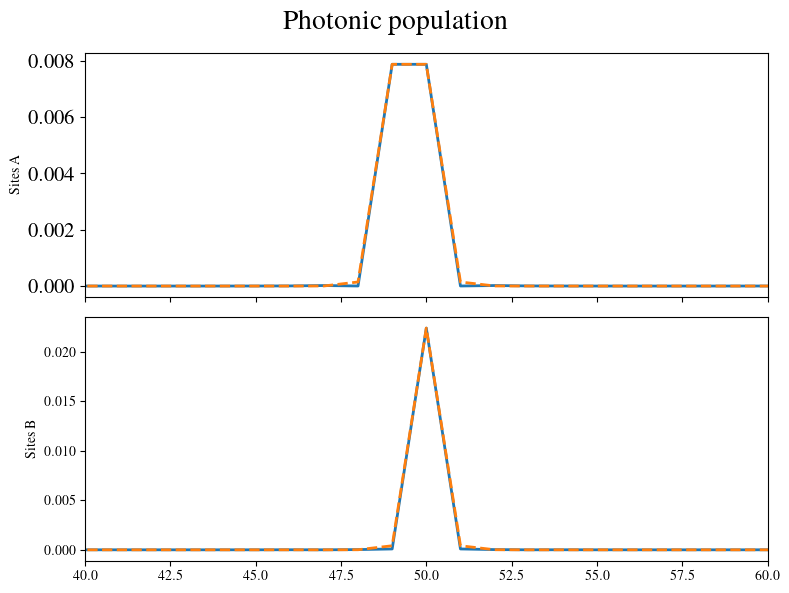

In [202]:
fig, ax = plt.subplots(figsize=(8,6),nrows=2,ncols=1,sharex=True,tight_layout=0)

fac = np.max(pop_phot[1::2,50])/np.max(vec_a**2)
ax[0].plot(pop_phot[1::2,50],lw=2)
ax[0].plot(fac*vec_a**2,ls="--",lw=2)

fac = np.max(pop_phot[::2,50])/np.max(vec_b**2)
ax[1].plot(pop_phot[::2,50],lw=2)
ax[1].plot(fac*vec_b**2,ls="--",lw=2)


plt.suptitle(f"Photonic population",fontsize=20)

plt.xlim(N//2 - 10,N//2 + 10)
ax[0].set_ylabel("Sites A",fontsize=10)
ax[1].set_ylabel("Sites B",fontsize=10)


ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.show()

## Multiple giant atoms coupled off-resonantly to an isolated FB

Here, we couple two giant atoms to the FB in order to show how it is possible to tailor the interactions.

In [21]:
omega1 = 3.5 #atom frequency
omega2 = 3.5
g = 0.05 #atom-cavity coupling

In [56]:
x = np.arange(0,N,1)
l = 1 # localization lenght

vec_b = -np.sqrt(2)*np.exp(-abs(x-(N//2))/l)/l
vec_a = np.zeros(N)
vec_a[:N//2] = np.exp(-abs(x[:N//2]-(N//2))/l)/l + np.exp(-abs(x[:N//2]-(N//2)-1)/l)/l
vec_a[N//2:] = np.flip(vec_a[:N//2])

In [57]:
c = np.sqrt(np.sum(vec_a**2) + np.sum(vec_b**2))

In [58]:
H = np.diag([eps_b/2,eps_a/2]*N + [omega1/2,omega2/2])
H += np.diag([-t_ab]*(2*N -1) + [0,0],k=1)
H += np.diag([-t_bb,-t_aa]*(N-1) + [0,0],k=2)

H[0,2*N-2] -= t_bb
H[0,2*N-1] -= t_ab

H[:-2:2,-2] = vec_b*g/c
H[1:-2:2,-2] = vec_a*g/c

d = 4
H[:-2:2,-1] = np.roll(vec_b*g/c,d)
H[1:-2:2,-1] = np.roll(vec_a*g/c,d)

H += np.conjugate(H.transpose())

In [59]:
t = np.linspace(0,2000,200)
pop, phot = time_evol(t,H,2,[1.,0.])

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.60it/s]


In [60]:
eigvals, _ = eigh(H)

gg = g**2/((eigvals[-2]-2)*c**2)
gg *= np.dot(vec_a,np.roll(vec_a,d)) + np.dot(vec_b,np.roll(vec_b,d))

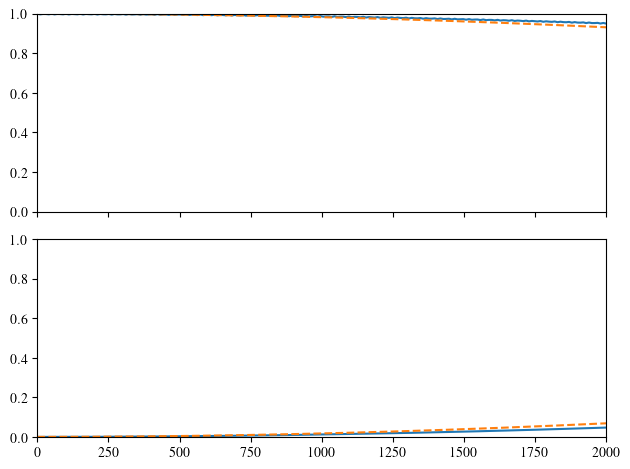

In [61]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)
 
ax[0].plot(t,pop[0,:]*np.conjugate(pop[0,:]))
ax[0].plot(t,np.cos(t*gg)**2, ls = "--", label=f"$\Omega = {gg:.2e}$")

ax[1].plot(t,pop[1,:]*np.conjugate(pop[1,:]))
ax[1].plot(t,np.sin(gg*t)**2, ls= "--")

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
ax[0].set_xlim(0,t[-1])


plt.show()

In [62]:
popp.append(pop*np.conjugate(pop))

In [65]:
np.shape(popp)

(4, 2, 200)

#### PlotJC_atom

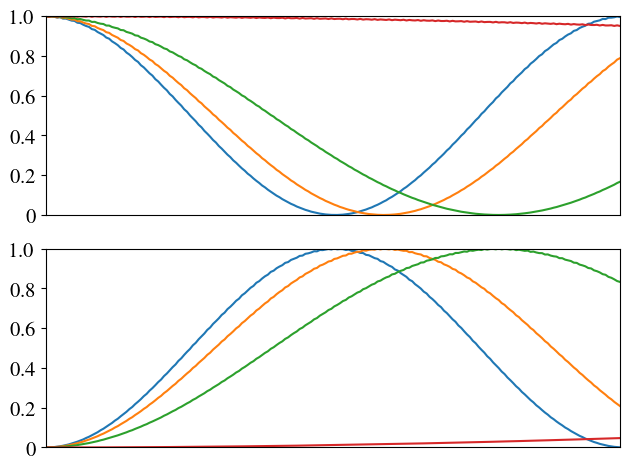

In [75]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)
 
#plt.suptitle(r"Time evolution of two off-resonant emitters"+"\n"+r"($\omega_a = 4t$, $g=0.05t$, $d=4$)",fontsize=20)

for i in [0,1,2,3]:
    pp = popp[i][0]
    ax[0].plot(t,pp)
    #ax[0].plot(t,np.cos(g1[i]*t)**2, ls = "--", label=f"$\ell = {ll[i]:d}$")
    
    pp = popp[i][1]
    ax[1].plot(t,pp)
    #ax[1].plot(t,np.sin(g1[i]*t)**2, ls = "--", label=f"$\ell = {ll[i]:d}$")


#ax[0].set_ylabel(r"P$_1$(t)",fontsize=20)
#ax[1].set_ylabel(r"P$_2$(t)",fontsize=20)
#ax[1].set_xlabel("Time",fontsize=20)

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)
ax[0].set_xlim(0,2000)
ax[0].set_xticks([])
ax[0].set_yticks([0,0.2,0.4,0.6,0.8,1.0],[0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
ax[1].set_yticks([0,0.2,0.4,0.6,0.8,1.0],[0,0.2,0.4,0.6,0.8,1.0],fontsize=15)

#plt.savefig("giant/comp_l.png")
plt.show()

## Multiple giant atoms coupled resonant to the FB

In [954]:
omega1 = 2. #atom frequency
omega2 = 2.
g = 0.07 #atom-cavity coupling

In [955]:
x = np.arange(0,N,1)
l = 2 # localization lenght

vec_b = -np.sqrt(2)*np.exp(-abs(x-(N//2))/l)/l
vec_a = np.zeros(N)
vec_a[:N//2] = np.exp(-abs(x[:N//2]-(N//2))/l)/l + np.exp(-abs(x[:N//2]-(N//2)-1)/l)/l
vec_a[N//2:] = np.flip(vec_a[:N//2])

In [956]:
c = np.sqrt(np.sum(vec_a**2) + np.sum(vec_b**2))

In [981]:
H = np.diag([eps_b/2,eps_a/2]*N + [omega1/2,omega2/2])
H += np.diag([-t_ab]*(2*N -1) + [0,0],k=1)
H += np.diag([-t_bb,-t_aa]*(N-1) + [0,0],k=2)

H[0,2*N-2] -= t_bb
H[0,2*N-1] -= t_ab

H[:-2:2,-2] = vec_b*g/c
H[1:-2:2,-2] = vec_a*g/c

d = 7
H[:-2:2,-1] = np.roll(vec_b*g/c,d)
H[1:-2:2,-1] = np.roll(vec_a*g/c,d)

H += np.conjugate(H.transpose())

In [982]:
test = np.sum(H[1:-2:2,-2]*H[1:-2:2,-1] + H[:-2:2,-2]*H[:-2:2,-1])/g**2

In [983]:
t = np.linspace(0,1000,500)
pop, phot = time_evol(t,H,2,[1.,0.])

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 51.22it/s]


In [984]:
gg1 = g*(np.sqrt(1-test) + np.sqrt(1+test))/2
gg2 = g*(np.sqrt(1+test) - np.sqrt(1-test))/2

In [988]:
1/c

0.7386160134202604

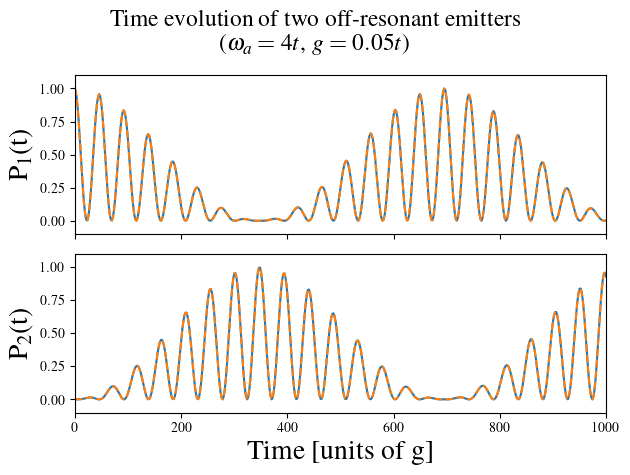

In [986]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)
 
plt.suptitle(r"Time evolution of two off-resonant emitters"+"\n"+r"($\omega_a = 4t$, $g=0.05t$)",fontsize=17)
ax[0].plot(t,pop[0,:]*np.conjugate(pop[0,:]))
ax[0].plot(t,(np.cos(0.97*gg1*t)*np.cos(0.97*gg2*t))**2, ls = "--")

ax[1].plot(t,pop[1,:]*np.conjugate(pop[1,:]))
ax[1].plot(t,(np.sin(0.97*gg1*t)*np.sin(0.97*gg2*t))**2, ls= "--")

ax[0].set_ylabel(r"P$_1$(t)",fontsize=20)
ax[1].set_ylabel(r"P$_2$(t)",fontsize=20)
ax[1].set_xlabel("Time [units of g]",fontsize=20)

ax[0].set_ylim(-0.1,1.1)
ax[1].set_ylim(-0.1,1.1)
ax[0].set_xlim(0,1000)
#ax[0].legend()

plt.show()

## Coupling to three point: isolating a CLS

In this section, we show the dynamic of two giant atoms coupled to a CLS. We expect photon-mediated interactions only when the atoms are coupled to overlapping CLSs.

In [403]:
omega1 = 3. #atom frequency
omega2 = 3.
g = 0.1 #atom-cavity coupling

In [203]:
H = np.diag([eps_b/2,eps_a/2]*N + [omega1/2,omega2/2])
H += np.diag([-t_ab]*(2*N -1) + [0,0],k=1)
H += np.diag([-t_bb,-t_aa]*(N-1) + [0,0],k=2)

d = 0
H[0,n-2] -= t_bb
H[0,n-1] -= t_ab

H[N,-2] += g/np.sqrt(2)
H[N-1,-2] -= g/2
H[N+1,-2] -= g/2

H[N+d,-1] += g/np.sqrt(2)
H[N-1+d,-1] -= g/2
H[N+1+d,-1] -= g/2

H += np.conjugate(H.transpose())

In [204]:
t = np.linspace(0,1000,1000)
pop, phot = time_evol(t,H,2,[1.,0.])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.24it/s]


In [208]:
eigvals, _ = eigh(H)
gg = (g**2)/(4*(eigvals[-1]-2))

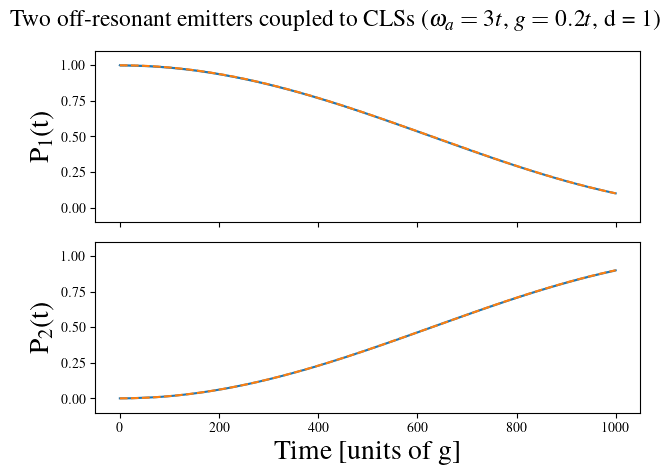

In [209]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)

plt.suptitle(r"Two off-resonant emitters coupled to CLSs ($\omega_a = 3t$, $g=0.2t$, d = 1)",fontsize=17)
ax[0].plot(t,pop[0]*np.conjugate(pop[0]))
ax[0].plot(t,np.cos(gg*t)**2, ls = "--", label=f"$\Omega = {gg:.2e}$")
ax[1].plot(t,pop[1]*np.conjugate(pop[1]))
ax[1].plot(t,np.sin(gg*t)**2, ls= "--")

ax[0].set_ylabel(r"P$_1$(t)",fontsize=20)
ax[1].set_ylabel(r"P$_2$(t)",fontsize=20)
ax[1].set_xlabel("Time [units of g]",fontsize=20)

ax[0].set_ylim(-0.1,1.1)
ax[1].set_ylim(-0.1,1.1)
#ax[0].legend()

plt.show()

In [207]:
pop_phot = np.zeros((n,len(t)))

for i in range(len(t)):
    pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))

In [216]:
vec = [10,50,100]

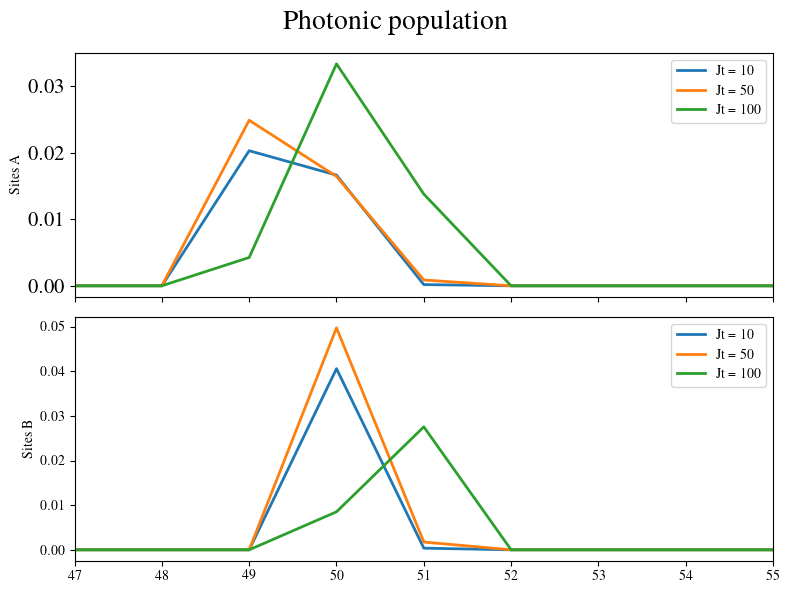

In [218]:
fig, ax = plt.subplots(figsize=(8,6),nrows=2,ncols=1,sharex=True,tight_layout=0)

for s in vec:
    ax[0].plot(pop_phot[1::2,s],label=f"Jt = {t[s]:.0f}",lw=2)
    ax[1].plot(pop_phot[::2,s],label=f"Jt = {t[s]:.0f}",lw=2)


plt.suptitle(f"Photonic population",fontsize=20)

plt.xlim(N//2 - 3,N//2 + 5)
ax[0].set_ylabel("Sites A",fontsize=10)
ax[1].set_ylabel("Sites B",fontsize=10)

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[0].legend(fontsize=10)
ax[1].legend(fontsize=10)


plt.show()